In [15]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import copy
from typing import Dict, List
import random
from typing import Tuple

class Struct:
    pass

UNDEFINED: int = -1

#### Class definitions

In [16]:
class Client:
    x: float
    y: float
    bandwidth: float
    id: int
    access_point_id: int = UNDEFINED
    
    def __init__(self, x_coord: str, y_coord: str, bandwidth_consumption: str) -> None:
        self.x = float(x_coord)
        self.y = float(y_coord)
        self.bandwidth = float(bandwidth_consumption)
        self.id = id

class AccessPoint:
    x: int = 0
    y: int = 0
    id: int = 0
    num_accessible_clients: int = 0
    
    def __init__(self, x_coord: int, y_coord: int, index: int) -> None:
        self.x = x_coord
        self.y = y_coord
        self.id = index
        self.num_accessible_clients: int = 0

class Solution:
    id: int = 0
    fitness: float = 0
    penalty: float = 0
    penalized_fitness: float = 0
    solution: Dict[int, int] = {}
    client_to_access_point: Dict[int, int] = {}
    clients_serviced_percentage = 0
    num_clients_per_access_point: Dict[int, int] = {}
    
    def __init__(self) -> None:
        self.id: int = 0
        self.fitness: float = 0
        self.penalty: float = 0
        self.penalized_fitness: float = 0
        self.solution: Dict[int, int] = {}
        self.client_to_access_point: Dict[int, int] = {}
        self.clients_serviced_percentage = 0
        self.num_clients_per_access_point: Dict[int, int] = {}

class ProblemData:
    access_points: List[AccessPoint] = []
    clients: List[Client] = []
    distance_ap_per_client: Dict[int, Dict[int, float]] = np.empty((81**2, 495))
    min_client_service_rate: float = 0.97
    num_clients: int = 495

#### Data definition

In [17]:
def read_clients_from_csv_file() -> List[Client]:
    # Função para ler dados de clientes de um arquivo CSV
    with open('data/clientes.csv', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        clients = []
        
        # Ler cada linha do arquivo CSV e criar instâncias de cliente
        for [x_coord, y_coord, bandwidth_consumption] in csv_reader:
            # Criar um novo cliente com coordenadas e consumo de largura de banda
            client = Client(x_coord, y_coord, bandwidth_consumption)
            # Adicionar o cliente à lista de clientes
            clients.append(client)
        
        # Ordenar os clientes com base no consumo de largura de banda
        clients = sorted(clients, key=lambda client: client.bandwidth)
        
        # Atribuir IDs aos clientes
        for index, client in enumerate(clients):
            client.id = index
        
    return clients

def define_problem_data() -> ProblemData:
    # Função para definir os dados do problema
    data = ProblemData()
    max_distance_for_access = 85
    
    # Criar pontos de acesso em uma grade 2D
    for x in range(0, 401, 5):
        for y in range(0, 401, 5):
            # Criar um novo ponto de acesso com coordenadas
            access_point = AccessPoint(x, y, len(data.access_points))
            # Adicionar o ponto de acesso à lista de pontos de acesso
            data.access_points.append(access_point)
    
    # Ler dados dos clientes do arquivo CSV
    data.clients = read_clients_from_csv_file()
    
    # Calcular a distância entre pontos de acesso e clientes e contar clientes acessíveis para cada ponto de acesso
    for access_point in data.access_points:
        for client in data.clients:
            # Calcular distância entre ponto de acesso e cliente
            distance_x = (access_point.x - client.x) ** 2
            distance_y = (access_point.y - client.y) ** 2
            distance = (distance_x + distance_y) ** 0.5
            # Armazenar a distância no dicionário de distâncias
            data.distance_ap_per_client[access_point.id][client.id] = distance
            
            # Verificar se o cliente está dentro do alcance do ponto de acesso
            if distance <= max_distance_for_access:
                # Incrementar o contador de clientes acessíveis para o ponto de acesso
                access_point.num_accessible_clients += 1
    
    return data

#### Solution utils

In [18]:
def activate_access_point(access_point_id: int, clients_solution: Dict[int, int], problem_data: ProblemData):
    # Função para ativar um ponto de acesso e atribuir clientes a ele
    total_bandwidth = 0

    for client in problem_data.clients:
        # Verificar se o cliente ainda não foi atribuído a um ponto de acesso
        not_served = clients_solution[client.id] == UNDEFINED
        # Verificar se a largura de banda total com este cliente não excede o limite
        bandwidth_within_limit = (total_bandwidth + client.bandwidth) <= 54
        # Verificar se o cliente está dentro do alcance do ponto de acesso
        within_range = problem_data.distance_ap_per_client[access_point_id][client.id] <= 85
        
        # Se o cliente ainda não foi atendido, a largura de banda está dentro do limite e o cliente está dentro do alcance do ponto de acesso
        if not_served and bandwidth_within_limit and within_range:
            # Atribuir o ponto de acesso ao cliente
            client.access_point_id = access_point_id
            # Atualizar a largura de banda total
            total_bandwidth += client.bandwidth
            # Atribuir o ponto de acesso ao cliente na solução
            clients_solution[client.id] = access_point_id

def initialize_solution(problem_data: ProblemData) -> Solution:
    # Função para inicializar a solução com pontos de acesso distribuídos uniformemente
    initial_solution = Solution()
    
    # Adicionar 30 pontos de acesso na grade 2D
    for access_point_id in range(0, 81**2, 220):
        initial_solution.solution[access_point_id] = access_point_id

    return initial_solution


#### Objective function

In [19]:

def objective_function_number_of_APs(solution: Solution, problem_data: ProblemData) -> Solution:
    # Função objetivo para calcular o número de pontos de acesso e a penalidade da solução
    client_to_access_point: Dict[int, int] = {}
    num_clients_serviced = 0
    
    # Inicializar o mapeamento cliente para ponto de acesso com valor UNDEFINED
    for client in problem_data.clients:
        client_to_access_point[client.id] = UNDEFINED
    
    # Ativar pontos de acesso para cada cliente na solução
    for access_point_id in solution.solution:
        activate_access_point(access_point_id, client_to_access_point, problem_data)
    
    # Calcular o número de clientes atendidos por ponto de acesso
    solution.num_clients_per_access_point: Dict[int, int] = {}
    for client in problem_data.clients:
        if client_to_access_point[client.id] != UNDEFINED:
            num_clients_serviced += 1
            if client_to_access_point[client.id] in solution.num_clients_per_access_point:
                solution.num_clients_per_access_point[client_to_access_point[client.id]] += 1
            else:
                solution.num_clients_per_access_point[client_to_access_point[client.id]] = 1
                
    # Calcular as restrições
    min_clients_constraint = max(0, problem_data.num_clients * problem_data.min_client_service_rate -  num_clients_serviced)
    max_APs_constraint = max(0, len(solution.solution) - 10)    
    
    # Calcular a aptidão, penalidade e aptidão penalizada da solução
    solution.fitness = len(solution.solution)
    solution.penalty = 1000 * min_clients_constraint**2 + 400 * max_APs_constraint**2
    solution.penalized_fitness = solution.fitness + solution.penalty
    solution.clients_serviced_percentage = num_clients_serviced / problem_data.num_clients
    solution.client_to_access_point = client_to_access_point
    
    return solution


#### RNVS and subfunctions

In [20]:
def shake(solution: Solution, k: int, problem_data: ProblemData) -> Solution:
    # Função para sacudir a solução, modificando aleatoriamente a solução
    new_solution = copy.deepcopy(solution)
    
    # Ordenar pontos de acesso por número de clientes e selecionar os k primeiros para substituição
    # sorted_ap_clients = sorted(new_solution.num_clients_per_access_point.values())
    # keys_to_replace = [key for key, value in new_solution.num_clients_per_access_point.items() if value in sorted_ap_clients[:k]]

    # Substituir os pontos de acesso selecionados por novos pontos de acesso aleatórios
    index = 0
    keys = list(solution.solution.keys())
    gen_keys: Dict[int, int] = {}
    while index < k:
        # old_key = random.choice(keys_to_replace)
        new_key = random.choice(keys)
        
        while new_key in gen_keys:
            new_key = random.choice(keys)

        gen_keys[new_key] = 0

        new_solution.solution.pop(new_key)
        new_key = int(81**2 * random.random())
        new_solution.solution[new_key] = new_key
        index += 1
    
    # Adicionar novos pontos de acesso se o tamanho da solução for menor que 9
    if len(new_solution.solution) <= 9:
        while len(new_solution.solution) < 30:
            key = int(81**2 * random.random())
            if not key in new_solution.solution:
                new_solution.solution[key] = key
    
    return new_solution

def neighborhood_change(x: Solution, y: Solution, k: int) -> Tuple[Solution, int]:
    # Função para mudar o bairro, atualizando a solução atual se a nova solução for melhor
    if (y.penalized_fitness < x.penalized_fitness or y.penalized_fitness == x.penalized_fitness and y.clients_serviced_percentage > x.clients_serviced_percentage):
        x = copy.deepcopy(y)
        k = 1
    else:
        k += 1
        
    return x, k

def best_improvement_local_search(solution: Solution, problem_data: ProblemData) -> Solution:
    # Função para realizar a busca local de melhoramento
    current_solution = copy.deepcopy(solution)
    improved = True
    
    # Loop até que não haja mais melhorias na solução
    while improved:
        improved = False
        for key in current_solution.solution.keys():
            # Sacudir a solução e aplicar a função objetivo
            new_solution = shake(current_solution, 1, problem_data)
            new_solution = objective_function_number_of_APs(new_solution, problem_data)
            
            # Se a nova solução for melhor, atualizar a solução atual
            if new_solution.penalized_fitness < current_solution.penalized_fitness:
                current_solution = new_solution
                improved = True
    
    return current_solution

def find_solution_using_vns(initial_solution: Solution, problem_data: ProblemData) -> Solution:
    # Função para encontrar a solução usando o VNS (Variable Neighborhood Search)
    max_num_evaluations = 2000
    num_evaluations = 0
    k_max = 3
    
    current_solution = initial_solution

    history = Struct()
    history.fit = []
    history.sol = []
    history.pen = []
    history.fit_pen = []
    
    # Loop até atingir o número máximo de avaliações
    while num_evaluations < max_num_evaluations:
        # print(f'avaliacao {num_evaluations}')
        k = 1
        # Loop sobre os valores de k
        while k <= k_max:
            new_solution = shake(current_solution, k, problem_data)
            #print(f'shake: {new_solution.solution}')
            
            # Aplicar busca local de melhoramento
            new_solution = best_improvement_local_search(new_solution, problem_data)
            #print(f'best_improvement_local_search: {new_solution.solution}')
            new_solution.id = num_evaluations
            
            # Verificar se a nova solução é melhor e atualizar a solução atual
            current_solution, k = neighborhood_change(current_solution, new_solution, k)
            #print(f'neighborhood_change: {current_solution.solution}')

            # Armazenar informações sobre a solução atual
            history.fit.append(current_solution.fitness)
            history.sol.append(current_solution.solution)
            history.pen.append(current_solution.penalty)
            history.fit_pen.append(current_solution.penalized_fitness)
            
            num_evaluations += 1
    return current_solution, history


#### Execution

In [21]:
# Definir dados do problema
problem_data = define_problem_data()
# Gerar solução inicial
initial_solution = initialize_solution(problem_data)
initial_solution = objective_function_number_of_APs(initial_solution, problem_data)

print(initial_solution.solution)

num_execucoes = 0
melhores_solucoes: List[Solution] = []
historicos_de_solucoes: List[Struct] = []

while num_execucoes < 5:
    melhor_solucao, historico = find_solution_using_vns(initial_solution, problem_data)
    print(f'execução = {num_execucoes} PAs = {melhor_solucao.fitness} Porcentagem de Clientes Atendidos = {melhor_solucao.clients_serviced_percentage} penalização = {melhor_solucao.penalized_fitness}')
    historicos_de_solucoes.append(historico)
    melhores_solucoes.append(melhor_solucao)
    num_execucoes += 1


{0: 0, 220: 220, 440: 440, 660: 660, 880: 880, 1100: 1100, 1320: 1320, 1540: 1540, 1760: 1760, 1980: 1980, 2200: 2200, 2420: 2420, 2640: 2640, 2860: 2860, 3080: 3080, 3300: 3300, 3520: 3520, 3740: 3740, 3960: 3960, 4180: 4180, 4400: 4400, 4620: 4620, 4840: 4840, 5060: 5060, 5280: 5280, 5500: 5500, 5720: 5720, 5940: 5940, 6160: 6160, 6380: 6380}
execução = 0 PAs = 12 Porcentagem de Clientes Atendidos = 0.9737373737373738 penalização = 1612
execução = 1 PAs = 13 Porcentagem de Clientes Atendidos = 0.9717171717171718 penalização = 3613
execução = 2 PAs = 11 Porcentagem de Clientes Atendidos = 0.9737373737373738 penalização = 411
execução = 3 PAs = 13 Porcentagem de Clientes Atendidos = 0.9797979797979798 penalização = 3613
execução = 4 PAs = 12 Porcentagem de Clientes Atendidos = 0.9737373737373738 penalização = 1612


#### Plots

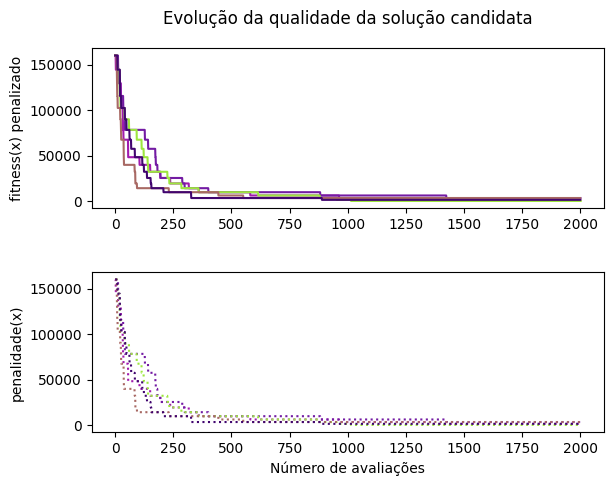

In [22]:
# Plotando a evolução da qualidade da solução candidata
fig, (ax1, ax2) = plt.subplots(2, 1)
cores_historico = [f'#{random.randint(0, 0xFFFFFF):06x}' for _ in range(num_execucoes)]
index_historico = 0
for historico in historicos_de_solucoes:
    s = len(historico.fit_pen)
    ax1.plot(np.linspace(0,s-1,s), historico.fit_pen, '-', color=cores_historico[index_historico])
    ax2.plot(np.linspace(0,s-1,s), historico.pen, ':', color=cores_historico[index_historico])
    index_historico += 1
    
fig.suptitle('Evolução da qualidade da solução candidata')
ax1.set_ylabel('fitness(x) penalizado')
ax2.set_ylabel('penalidade(x)')
ax2.set_xlabel('Número de avaliações')
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.show()

def plot_triangle(x, y, size, color):
    plt.plot(x, y, marker='^', markersize=size, color=color, linestyle='None')

def plot_circle(x, y, size, color):
    plt.plot(x, y, marker='o', markersize=size, color=color, linestyle='None')

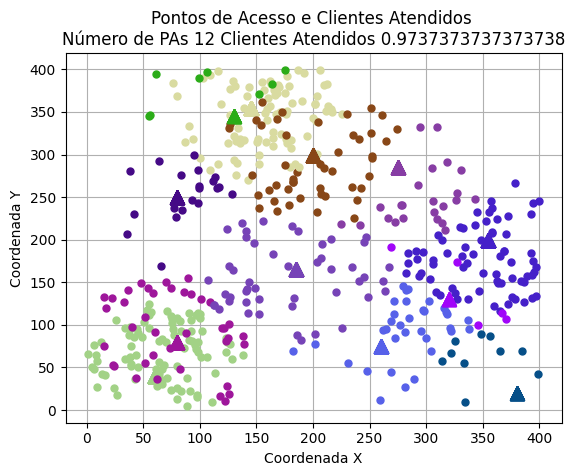

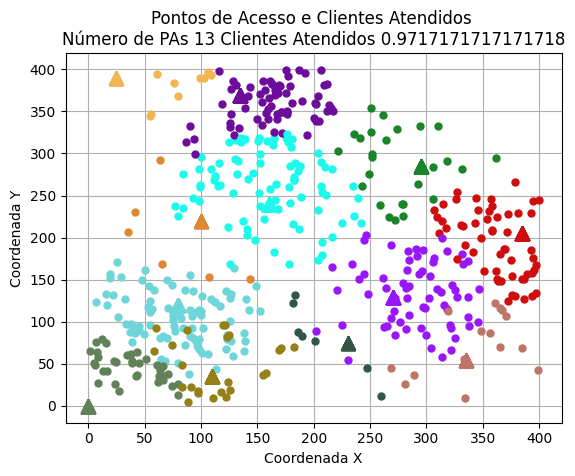

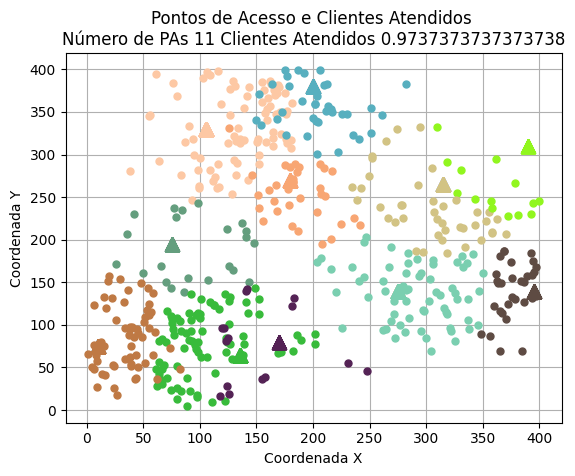

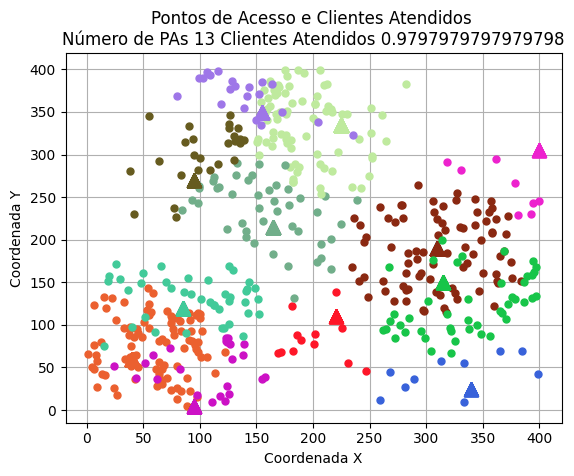

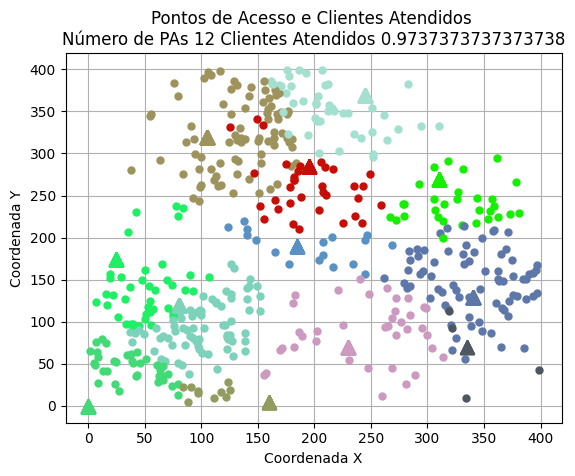

In [23]:
for solution in melhores_solucoes:
    # Gerar uma lista de cores aleatórias para os pontos de acesso
    access_point_colors = [f'#{random.randint(0, 0xFFFFFF):06x}' for _ in range(len(solution.solution))]

    colors: Dict[int, str] = {}

    index = 0
    for access_point_id in solution.num_clients_per_access_point:
        colors[access_point_id] = access_point_colors[index]
        index += 1

    active_access_points: Dict[int, float] = {}
        
    for client_id, access_point_id in solution.client_to_access_point.items():
        if access_point_id != UNDEFINED:
            plot_triangle(problem_data.access_points[access_point_id].x, problem_data.access_points[access_point_id].y, 10, color=colors[access_point_id])
            plot_circle(problem_data.clients[client_id].x, problem_data.clients[client_id].y, 5, color=colors[access_point_id])

    # Configurar o gráfico
    plt.xlabel('Coordenada X')
    plt.ylabel('Coordenada Y')
    label = f'Número de PAs {solution.fitness} Clientes Atendidos {solution.clients_serviced_percentage}'
    plt.title(f'Pontos de Acesso e Clientes Atendidos \n{label}')
    plt.grid(True)

    # Mostrar o gráfico
    plt.show()
